In [8]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [9]:
# Read Oklahoma county graph from the json file "OK_county.json"
#filepath = 'districting-data\\'
filename = 'MT_county.json'

G = read_graph_from_json( filename )

In [10]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

Node 0 represents Broadwater County, which had a population of 6774 in the 2020 census.
Node 1 represents Big Horn County, which had a population of 13124 in the 2020 census.
Node 2 represents Sanders County, which had a population of 12400 in the 2020 census.
Node 3 represents Lincoln County, which had a population of 19677 in the 2020 census.
Node 4 represents Granite County, which had a population of 3309 in the 2020 census.
Node 5 represents Custer County, which had a population of 11867 in the 2020 census.
Node 6 represents Richland County, which had a population of 11491 in the 2020 census.
Node 7 represents Wibaux County, which had a population of 937 in the 2020 census.
Node 8 represents Golden Valley County, which had a population of 823 in the 2020 census.
Node 9 represents Carbon County, which had a population of 10473 in the 2020 census.
Node 10 represents Toole County, which had a population of 4971 in the 2020 census.
Node 11 represents Blaine County, which had a populati

In [11]:
# Let's impose a 2% population deviation (+/-1%)
# (Usually, we use 1% deviation, but this instance is infeasible at 1%.)
deviation = 0.02

k = 2  # desired number of districts
total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k

import math
#L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
#U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
L = math.floor( total_population / k ) #one person deviation
U = math.ceil( total_population / k )  #one person deviation
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 542112 and U = 542113 and k = 2


In [12]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

Set parameter Username
Set parameter LicenseID to value 2628084
Academic license - for non-commercial use only - expires 2026-02-25


In [13]:
m.reset()

Discarded solution information


In [14]:
# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY ) # x[i,j] = 1 if county i is assigned to district j
y = m.addVars( G.edges, vtype=GRB.BINARY )    # y[u,v] = 1 when edge {u,v} is cut

In [15]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

## Equivalently, we could write:
#m.setObjective( gp.quicksum( y ), GRB.MINIMIZE )

In [16]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [17]:
# solve IP model
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 336 rows, 250 columns and 1164 nonzeros
Model fingerprint: 0x44232123
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 58 rows and 56 columns
Presolve time: 0.00s
Presolved: 278 rows, 194 columns, 940 nonzeros
Variable types: 0 continuous, 194 integer (194 binary)

Root relaxation: objective 0.000000e+00, 86 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   56          -    0.00000      -     -    0s
     0     0    1.00000    0   5

In [18]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The number of cut edges is 20.0
District 0 has these nodes = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 24, 27, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 55] and this population = 542112
The corresponding county names are = ['Broadwater', 'Big Horn', 'Custer', 'Richland', 'Wibaux', 'Golden Valley', 'Carbon', 'Toole', 'Blaine', 'Judith Basin', 'Park', 'Roosevelt', 'Fallon', 'McCone', 'Stillwater', 'Dawson', 'Powder River', 'Hill', 'Yellowstone', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Madison', 'Beaverhead', 'Musselshell', 'Chouteau', 'Meagher', 'Rosebud', 'Sweet Grass', 'Pondera', 'Garfield', 'Carter', 'Gallatin', 'Liberty', 'Silver Bow', 'Fergus']

District 1 has these nodes = [2, 3, 4, 13, 19, 22, 23, 25, 26, 28, 29, 31, 35, 46, 53, 54] and this population = 542113
The corresponding county names are = ['Sanders', 'Lincoln', 'Granite', 'Powell', 'Teton', 'Glacier', 'Lake', 'Treasure', '

In [19]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 24, 27, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 55] connected? True
Is district = [2, 3, 4, 13, 19, 22, 23, 25, 26, 28, 29, 31, 35, 46, 53, 54] connected? False


In [20]:
# Let's draw it on a map
import geopandas as gpd

In [21]:
# Read Oklahoma county shapefile from "OK_county.shp"
#filepath = 'districting-data\\'
filename = 'MT_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

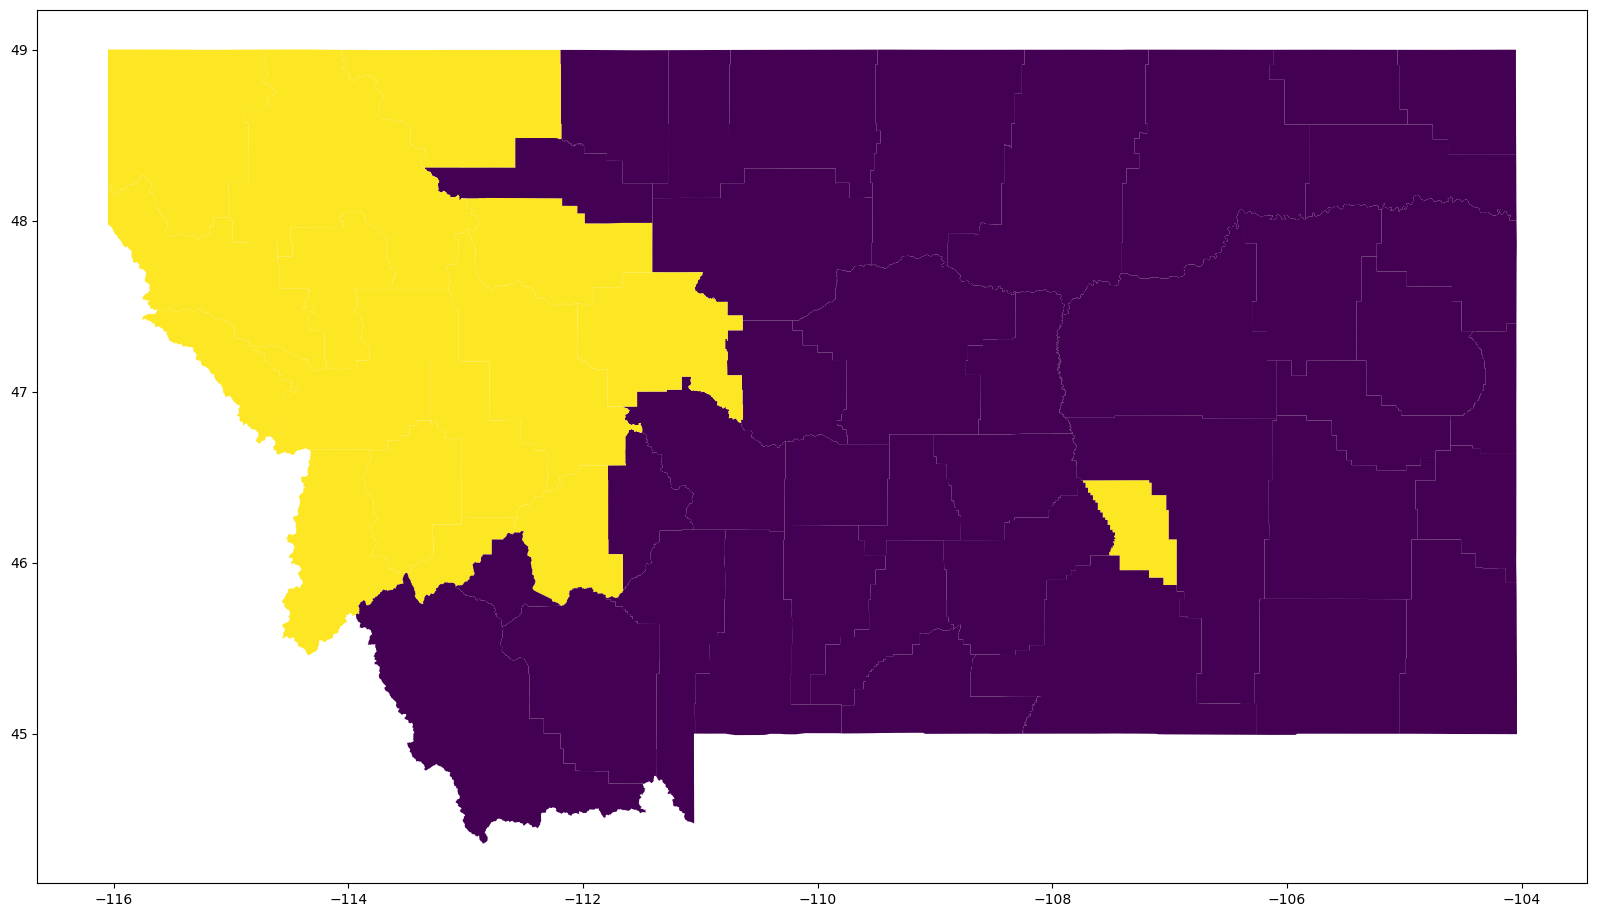

In [22]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment',figsize=(20,30)).get_figure()